# Evaluation of model performance under missing values
In this notebook we will explore the ability of the clinical transformer to perform predictions when missing values are added to the model. 

* For each input sample, add a determined number of missing features by randomly setting each feature to either the original value or nan. 
* Predict the survival score using the clinical transformer for each sample 
* Evaluate using the concordance index
* Repeat the process by iterating over the number of nan features (1 to 9).
* Repeat the whole process 100 times with different random seed to get a variability of the predictions (each prediction a sample will have a different set of features being set to nan).

In [1]:
import sys

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [3]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import survival_attention_scores
from xai.models.SimplifiedClinicalTransformer.Topologies.BertLikeTransformer.Explainer.SurvivalExplainer import survival_output_scores
from xai.models import load_transformer


In [5]:
import pandas as pd
from samecode.random import set_seed
import numpy as np 
import seaborn as sns

In [6]:
from xai.models.explainer import TransformerSurvivalEvaluator
from xai.models.explainer import compute_performance_folds


In [7]:
from samecode.plot.pyplot import subplots
from samecode.survival.plot import KMPlot
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index as lfcindex
import seaborn as sns


## Dataset

In [22]:
path = '../results/runs/TransferLearningSurvival/model.E001000.h5/'
run = 'fold-0_id-0'
sample_id = 'sample_id'
epoch = 87

## Impact of NaNs to the prediction

In [17]:
def score_nn(nn=0, split='train', data_seed=0):
    data = pd.read_csv('../data/dataset-{}.data.csv'.format(split))
    data['sample_id'] = data.index
    features = ["f_{}".format(i) for i in range(10)]

    set_seed(data_seed)
    for ix,i in data.iterrows():
        nans = np.array([np.nan]*nn + [1]*(10-nn))
        np.random.shuffle(nans)

        data.loc[ix, features] = i[features] * nans
    
    set_seed(0)
    trainer = load_transformer(path, run, epoch=epoch)
    transformed_data = trainer.data_converter.transform(data).reset_index(drop=True)
    
    evaluator = TransformerSurvivalEvaluator(model=trainer)
    train_data = survival_output_scores(transformed_data, evaluator, iterations=1, sample_id=sample_id)
    
    return lfcindex(train_data['time'], train_data['β'], train_data['event'])

In [25]:
base_score = score_nn(nn=0, split='test', data_seed=0)

In [23]:
scores = []
for mi in range(1, 10):
    for ds in range(100):
        ci = score_nn(nn=mi, split='test', data_seed=ds)
        scores.append(dict(
            missing_features = mi,
            cindex=ci,
            data_seed=ds
        ))

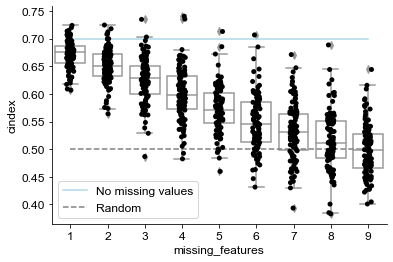

In [44]:
sns.boxplot(
    data = pd.DataFrame(scores),
    x='missing_features', y='cindex', color='white'
);

sns.stripplot(
    data = pd.DataFrame(scores),
    x='missing_features', y='cindex', color='black'
);

sns.lineplot(x=[0, 8], y=[base_score, base_score], linestyle='-', color='lightblue', label='No missing values')
sns.lineplot(x=[0, 8], y=[0.5, 0.5], linestyle='--', color='gray', label='Random')
sns.despine()

These results show that the clinical transformer can make meaningful predictions even when there are NaNs in the data. In this example, up to 4 random NaNs per sample the mean results are above a cindex of 0.6. 

**Note that the clinical transformer is not imputing the missing data but calculating the survival score in the absense of the given missing data**

# Impact of removing entire features
In this test we remove the entire feature (imagine having a dataset where you don't have one of the features). The clinical transformer still can make predictions, but, would be informative to evaluate the effect of each feature missingnes to the overall performance. 

Features 5 7 and 8 are related to the outcome, therefore, we will inspect the impact of removing each individual feature.

In [49]:
for feature in ['f_5', 'f_7', 'f_8', 'f_0', 'f_1', 'f_2', 'f_3', 'f_4', 'f_6', 'f_9']:
    data = pd.read_csv('../data/dataset-{}.data.csv'.format('test'))
    data['sample_id'] = data.index
    
    data[feature] = np.nan
    
    set_seed(0)
    trainer = load_transformer(path, run, epoch=epoch)
    transformed_data = trainer.data_converter.transform(data).reset_index(drop=True)
    
    evaluator = TransformerSurvivalEvaluator(model=trainer)
    train_data = survival_output_scores(transformed_data, evaluator, iterations=1, sample_id=sample_id)
    
    ci = lfcindex(train_data['time'], train_data['β'], train_data['event'])
    print(feature, ci)

f_5 0.684712616265204
f_7 0.7009301216312902
f_8 0.5122823753875507
f_0 0.691390412592416
f_1 0.7028380634390651
f_2 0.6985451943715717
f_3 0.7021225852611496
f_4 0.6990221798235153
f_6 0.6949678034819938
f_9 0.6935368471261627


As observed, feature 8 is the most important feature for the model. When this feature is removed the c-index drops to a random model.